In [246]:
# https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras

import sys
import math

# !{sys.executable} -m pip install --upgrade pip

try:
    import numpy as np
except ModuleNotFoundError:
    !{sys.executable} -m pip install numpy
    import numpy as np
    

try:
    import pandas as pd
except ModuleNotFoundError:
    !{sys.executable} -m pip install pandas
    import pandas as pd

    
try:
    import matplotlib
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt

    
try:
    import psycopg2
except ModuleNotFoundError:
    !{sys.executable} -m pip install psycopg2
    import psycopg2
    
    
try:
    import scipy
except ModuleNotFoundError:
    !{sys.executable} -m pip install scipy
    import scipy

        
try:
    import sklearn
except ModuleNotFoundError:
    !{sys.executable} -m pip install sklearn
    import sklearn

    
try:
    import statsmodels
except ModuleNotFoundError:
    !{sys.executable} -m pip install statsmodels
    import statsmodels


try:
    import theano
except ModuleNotFoundError:
    !{sys.executable} -m pip install theano
    import theano


try:
    import tensorflow
except ModuleNotFoundError:
    !{sys.executable} -m pip install tensorflow
    import tensorflow


try:
    import keras
except ModuleNotFoundError:
    !{sys.executable} -m pip install keras
    import keras
    
try:
    import ann_visualizer
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install ann_visualizer
    import ann_visualizer
    
try:
    import graphviz
except ModuleNotFoundError:
    !{sys.executable} -m pip install graphviz
    import graphviz
    
    
from keras.models import Sequential
from keras.layers import Dense

In [247]:
"""
Make plot outputs appear and be stored within the notebook
"""
%matplotlib inline

"""
fix random seed for reproducibility
"""
np.random.seed(7)

In [248]:
from numpy import genfromtxt

def get_df():
    """
    Query the Postgres database and return the data set in a Pandas dataframe with (x,y)
    """
    
    # conn = psycopg2.connect(DATABASE_URL)
    # cur = conn.cursor()
    # cur.execute('select * from project2')
    data = genfromtxt(r"C:\Users\cccarmer\Documents\asu\EEE 511\code\proj3\data.csv")
    df = pd.DataFrame(data, columns=['y'])
    # conn.commit()
    # conn.close()
    
    return df


In [249]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

data = get_df()

data

# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)


In [250]:

TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)


Number of entries (training set, test set): (165, 110)
Original training data shape:
(163, 1)
New training data shape:
(163, 1, 1)


In [251]:
%%capture

def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, input_shape = (1, window_size)))
    # model.add(Dense(4, input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 150, 
              batch_size = 10, 
              verbose = 2)
    
    return(model)

# Fit the first model.
# model1 = fit_model(train_X, train_Y, window_size)
model1 = fit_model(train_X, train_Y, window_size)


In [252]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)


Training data score: 19.99 RMSE
Test data score: 24.69 RMSE


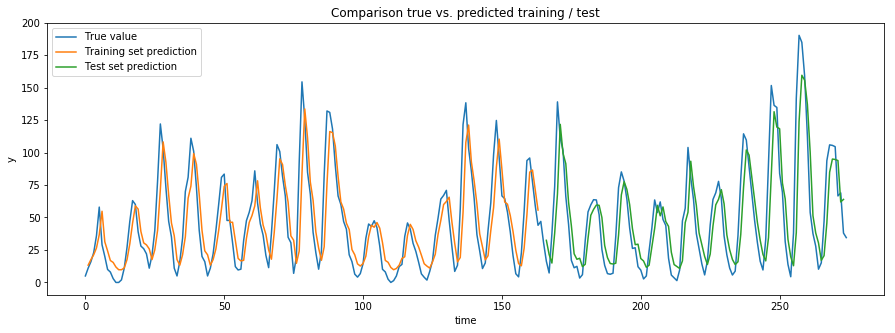

In [253]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
# plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("time")
plt.ylabel("y")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

In [254]:

from ann_visualizer.visualize import ann_viz;
ann_viz(model1, title="My first neural network")


ValueError: invalid literal for int() with base 10: ''